# **Árboles de Decisión**

**Resumen:** En este capítulo veremos cómo entrenar y visualizar árboles de decisión para clasificación y regresión, así como explorar algunos aspectos avanzados como la sensibilidad a la orientación de los ejes y la varianza alta de estos modelos.

In [1]:
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "img"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Entrenamiento y visualización de un Árbol de Decisión

En esta sección entrenamos un árbol de decisión para clasificar el conjunto de datos Iris utilizando únicamente dos características (la longitud y anchura del pétalo) y lo visualizamos.

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Cargamos el dataset Iris en formato DataFrame (as_frame=True)
iris = load_iris(as_frame=True)
# Seleccionamos dos características para simplificar la visualización:
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

# Creamos y entrenamos un árbol de decisión con profundidad máxima 2 
# ( baja solo dos niveles en el arbol, 0,1 y 2)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

**Árbol de Decisión para el dataset Iris.**

**Resumen:** Se entrena un árbol simple que utiliza dos características para clasificar las flores del dataset Iris.

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=str(IMAGES_PATH / "iris_tree.dot"),  # La ruta puede variar respecto al libro
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [5]:
from graphviz import Source

# Visualizamos el archivo .dot generado para ver la estructura del árbol
Source.from_file(IMAGES_PATH / "iris_tree.dot")

ModuleNotFoundError: No module named 'graphviz'

Graphviz también provee la herramienta de línea de comandos `dot` para convertir archivos `.dot` a diversos formatos. El siguiente comando convierte el archivo .dot en una imagen PNG.

In [6]:
# Código extra: conversión del archivo .dot a PNG
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

"dot" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# Realizando Predicciones

En esta parte se visualizan las fronteras de decisión del árbol entrenado y se muestra cómo predecir la clase para nuevas instancias.

**Resumen:** Se crea una malla de puntos en el espacio de características, se predicen las clases con el árbol y se grafican las fronteras junto con los datos originales.

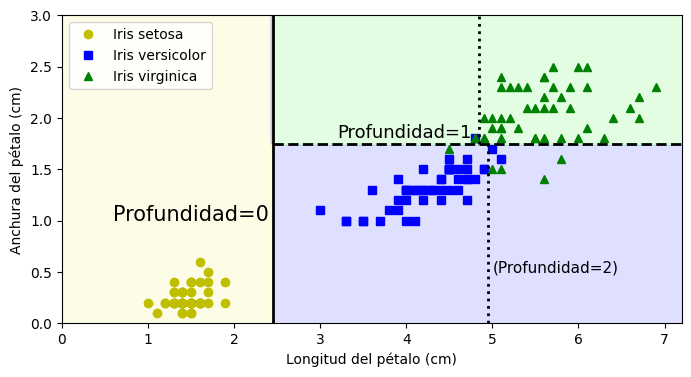

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#  detalles de formateo para la visualización:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

# Creamos una malla de puntos en el rango adecuado para las características
lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
# Predecimos la clase para cada punto de la malla
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

# Graficamos los datos originales
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

#  se entrena un árbol más profundo (max_depth=3) para mostrar fronteras adicionales
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
# Obtenemos algunos umbrales del árbol para dibujar líneas que indiquen las divisiones
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Longitud del pétalo (cm)")
plt.ylabel("Anchura del pétalo (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Profundidad=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Profundidad=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Profundidad=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

Puedes acceder a la estructura interna del árbol a través del atributo `tree_`:

In [ ]:
tree_clf.tree_

In [ ]:
tree_clf.feature_importances_

array([0.56199095, 0.43800905])

Para obtener más información, consulta la documentación de la clase:

```python
help(sklearn.tree._tree.Tree)
```

También puedes revisar el material extra que aparece a continuación.

# Estimación de Probabilidades de Clase

Los árboles de decisión también pueden predecir las probabilidades de que una instancia pertenezca a cada clase.

In [ ]:
# Predice las probabilidades para la instancia [x=5,y=1.5]
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [9]:
# Predice la clase para la misma instancia
tree_clf.predict([[5, 1.5]])

array([1])

# Hiperparámetros de Regularización

En esta sección se explora el efecto de ciertos hiperparámetros (como `min_samples_leaf`) sobre el comportamiento del árbol. Utilizaremos el conjunto de datos _moons_ para este ejemplo.

**Resumen:** Se comparan árboles sin restricciones y con restricciones (mínimo número de muestras por hoja) para ver cómo afecta la complejidad del modelo y la precisión en datos de prueba.

In [10]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

# Árbol sin restricciones
tree_clf1 = DecisionTreeClassifier(random_state=42)
# Árbol con restricción: mínimo 5 muestras por hoja
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [ ]:
# función para graficar las fronteras de decisión
def plot_decision_boundary(clf, X, y, axes, cmap):
    """
    Dibuja las fronteras de decisión de un clasificador.
    
    Parámetros:
      - clf: el clasificador entrenado.
      - X, y: datos de entrada y etiquetas.
      - axes: límites del gráfico.
      - cmap: mapa de colores a utilizar.
    """
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# Graficamos las fronteras de ambos modelos en subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("Sin restricciones")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

In [ ]:
# Generamos un conjunto de prueba para evaluar la precisión de ambos modelos
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
print("Precisión árbol sin restricciones:", tree_clf1.score(X_moons_test, y_moons_test))
print("Precisión árbol con min_samples_leaf=5:", tree_clf2.score(X_moons_test, y_moons_test))

# Regresión con Árboles de Decisión

Ahora veremos cómo utilizar árboles de decisión para problemas de regresión. Comenzamos preparando un conjunto de entrenamiento sencillo basado en una función cuadrática.

**Resumen:** Se entrenan árboles de regresión con diferentes profundidades y se visualizan las predicciones junto con los puntos de entrenamiento.

Vamos a preparar un conjunto de entrenamiento cuadrático sencillo:

**Ejemplo de código:**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
# Generamos 200 puntos en el intervalo aproximadamente [-0.5, 0.5]
X_quad = np.random.rand(200, 1) - 0.5  # única característica de entrada
# La variable objetivo es una función cuadrática con algo de ruido
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

# Entrenamos un árbol de regresión con profundidad máxima 2
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

In [ ]:
#  exportamos la estructura del árbol a un archivo .dot para visualizarlo
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

In [ ]:
# Entrenamos otro árbol de regresión con una mayor profundidad (max_depth=3)
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

In [ ]:
# Mostramos los umbrales de los nodos en cada árbol para comparar
print("Umbrales árbol (max_depth=2):", tree_reg.tree_.threshold)
print("Umbrales árbol (max_depth=3):", tree_reg2.tree_.threshold)

In [ ]:
#  función para graficar las predicciones de un árbol de regresión
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    """
    Dibuja las predicciones de un árbol de regresión junto con los datos de entrenamiento.
    """
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

# Se crean dos subplots para comparar los árboles con diferentes profundidades
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

# Dibujamos las líneas que indican los umbrales en cada nodo
th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Profundidad=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Profundidad=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Profundidad=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Profundidad=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

In [ ]:
#  exploración de la regularización en árboles de regresión
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("Sin restricciones")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

# Sensibilidad a la Orientación de los Ejes

Rotar el conjunto de datos puede producir fronteras de decisión completamente diferentes.

**Resumen:** Se ilustra cómo una rotación (en este caso, 45°) del conjunto de datos cambia la forma en que el árbol de decisión divide el espacio, demostrando que la orientación de los ejes puede influir notablemente en la partición generada.

In [ ]:
np.random.seed(6)
# Generamos 100 puntos en un cuadrado centrado en el origen
X_square = np.random.rand(100, 2) - 0.5
# Definimos la etiqueta en función de si la primera característica es positiva
y_square = (X_square[:, 0] > 0).astype(np.int64)

# Rotamos el conjunto de datos 45° (π/4 radianes)
angle = np.pi / 4  # 45 grados
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

# Entrenamos un árbol en el conjunto original y otro en el conjunto rotado
tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

# Graficamos las fronteras de decisión para ambos casos
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Aplicamos PCA para ver la influencia de la rotación en un espacio de componentes principales
pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

In [ ]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
# Dibujamos líneas en función de los umbrales del árbol en el espacio PCA
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Profundidad=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Profundidad=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

# Los Árboles de Decisión Tienen Alta Varianza

Hemos visto que pequeños cambios en el conjunto de datos (como una rotación) pueden producir un árbol muy distinto. Ahora demostraremos que entrenar el mismo modelo con los mismos datos puede generar modelos diferentes en cada ejecución, ya que el algoritmo CART (utilizado por Scikit-Learn) es estocástico.

**Resumen:** Se entrena un árbol con un `random_state` distinto para evidenciar que la estructura del árbol puede variar y, por ende, las fronteras de decisión también.

In [ ]:
# Entrenamos un árbol con un valor distinto de random_state
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

In [ ]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# Dibujamos líneas en función de los umbrales obtenidos
th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Profundidad=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Profundidad=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Longitud del pétalo (cm)")
plt.ylabel("Anchura del pétalo (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

# Material Extra – Accediendo a la Estructura del Árbol

Un `DecisionTreeClassifier` entrenado posee un atributo `tree_` que almacena la estructura interna del árbol.

In [ ]:
tree = tree_clf.tree_
tree

Puedes obtener el número total de nodos del árbol:

In [ ]:
tree.node_count

Además, se encuentran disponibles otros atributos autoexplicativos:

In [ ]:
print("Profundidad máxima:", tree.max_depth)
print("Número máximo de clases:", tree.max_n_classes)
print("Número de características:", tree.n_features)
print("Número de salidas:", tree.n_outputs)
print("Número de hojas:", tree.n_leaves)

Toda la información sobre los nodos se almacena en arrays de NumPy. Por ejemplo, la impureza de cada nodo:

In [ ]:
tree.impurity

El nodo raíz se encuentra en el índice 0. Los hijos izquierdo y derecho del nodo _i_ son `tree.children_left[i]` y `tree.children_right[i]`, respectivamente. Por ejemplo, los hijos del nodo raíz son:

In [ ]:
tree.children_left[0], tree.children_right[0]

Cuando los hijos izquierdo y derecho son iguales, significa que el nodo es hoja (los identificadores en este caso son arbitrarios):

In [ ]:
tree.children_left[3], tree.children_right[3]

Para obtener los identificadores de los nodos hoja:

In [ ]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

Los nodos que no son hoja se denominan _nodos de división_. La característica que utilizan para dividir el espacio está en el array `feature` (para los nodos hoja, estos valores deben ignorarse):

In [ ]:
tree.feature

Y los umbrales correspondientes son:

In [ ]:
tree.threshold

También se encuentra disponible el número de instancias por clase que alcanzaron cada nodo:

In [ ]:
print("Valor (conteo por clase) en cada nodo:\n", tree.value)
print("Número de muestras en cada nodo:\n", tree.n_node_samples)
print("Verificación (la suma de valores por nodo coincide con n_node_samples):",
      np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples))

**Calcular la profundidad de cada nodo:**  
El siguiente código recorre el árbol (usando una pila) para asignar la profundidad a cada nodo.

In [ ]:
def compute_depth(tree_clf):
    """
    Calcula la profundidad de cada nodo en un árbol de decisión entrenado.
    
    Devuelve:
      - depth: un array con la profundidad de cada nodo.
    """
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]  # (nodo, profundidad)
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        # Si el nodo no es hoja, añadimos sus hijos a la pila
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
print("Profundidad de cada nodo:", depth)

**Obtener los umbrales de todos los nodos de división a profundidad 1:**

In [ ]:
features_depth1 = tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]
thresholds_depth1 = tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]
print("Características en nodos a profundidad 1:", features_depth1)
print("Umbrales en nodos a profundidad 1:", thresholds_depth1)